In [1]:
from PIL import Image
import os
import numpy as np
import cv2 as cv
import tensorflow as tf
from matplotlib import pyplot as plt

My idea was that since a multi object detection CNN is quite complicated, I'd try the next best thing. Namely split the image in several smaller sections and estimate how much roof area is contained within each square, since if the goal is to build solar cells, we don't need to just know where the roofs are, but also how much potential roof area is available.

In [2]:
img_path='C:/Users/Ilin/OneDrive/Desktop/Fun Stuff/dida Test/images/'#put folder path for images here
lbl_path='C:/Users/Ilin/OneDrive/Desktop/Fun Stuff/dida Test/labels/'

These functions are here to split an image into several squares, and estimate the area within each (I will use the pixels in the label images as non-zero areas).

In [19]:


def even_split(arr, splits):
    '''Splits array into splits x splits squares'''
    vert_split=np.vsplit(arr, splits)
    chunks=[]
    for i in vert_split:
        chunks.extend(np.hsplit(i, splits))
        
    return chunks

def square_areas(arr):
    '''Calculates the "area" in each square '''
    area=[]
    for i in arr:
        summon=np.sum(i)
        area.append(summon)
        
    return np.asarray(area)
    

In [20]:

#just to make everything tidier for ease of access to the files later on
def list_image_files(image_path, label_path, split_percentage = [70, 30]):
    '''Divides images in folder into training, validation and the end test files'''
    
    imlst=os.listdir(image_path)
    img_num=len(imlst)

    lblst=os.listdir(label_path)
    lbl_num=len(lblst)
    imglbl_diff=img_num-lbl_num

    files = imlst[:-(imglbl_diff)]
    test_set=imlst[-(imglbl_diff):]

    split_training = int(split_percentage[0] * lbl_num / 100)
    

    return files[0:split_training], files[split_training:], test_set

In [21]:
#sorting everything in a way that is readable to tensorflow
def data_load(files, image_path, label_path):
    '''Converts data into readable format for TensorFlow, as well as create labels.'''
    img_num=len(files)
    X = []
    Y = []
    
    for file in files:
        img=cv.imread(image_path+file, cv.IMREAD_GRAYSCALE)/255
        #I've added a ceiling function to make all the non-zero pixels i.e. where there is a roof, into 1s to make things more convenient
        lbl=np.ceil(cv.imread(label_path+file, cv.IMREAD_GRAYSCALE)/255)
        labels=square_areas(even_split(lbl, 8))
        X.append(img)
        #I couldn't think of a clever way to reduce the number of features in the output layer, I'd actually apreciate some advice on that topic
        Y.append(labels)
        
    X=np.array(X)


    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result


In [6]:
train_f, validation_f, testing= list_image_files(img_path, lbl_path)

In [7]:
raw_train=data_load(train_f, img_path, lbl_path)
raw_val=data_load(validation_f, img_path, lbl_path)

In [8]:
raw_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.float32, name=None))>

Tensorflow recommended optimisation stuff.

In [9]:
def format_instance(image, label):
    return image, ([label[0], label[1], label[2], label[3], label[4], label[5], label[6], label[7], label[8], label[9], label[10], label[11], label[12], label[13], label[14], label[15], label[16], label[17], label[18], label[19], label[20], label[21], label[22], label[23], label[24], label[25], label[26], label[27], label[28], label[29], label[30], label[31], label[32], label[33], label[34], label[35], label[36], label[37], label[38], label[39], label[40], label[41], label[42], label[43], label[44], label[45], label[46], label[47], label[48], label[49], label[50], label[51], label[52], label[53], label[54], label[55], label[56], label[57], label[58], label[59], label[60], label[61], label[62], label[63]])



In [10]:
BATCH_SIZE = 64



def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
   # dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [11]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_f) // 4)
    dataset = dataset.repeat()
    return dataset


In [12]:
train_ds = tune_training_ds(raw_train)

In [13]:
validation_ds = tune_validation_ds(raw_val)

Finnally the fun part, the actuall CNN. I didn't experiment too much with the architecture here, just found a simple example architecture online and used it, though I would like to experiment with the architecture to see how much it impacts the end result. I followed the Tensorflow API format in creating the network.

In [14]:
inputs=tf.keras.layers.Input(shape=(256, 256, 1))

x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(256, 256, 1))(inputs)
x = tf.keras.layers.AveragePooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
x = tf.keras.layers.AveragePooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
x = tf.keras.layers.AveragePooling2D(2,2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(units = '64')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="OBJ_ID_scratch")
    
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(),metrics=tf.keras.metrics.MeanSquaredError())



model.summary()

Model: "OBJ_ID_scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 average_pooling2d (AverageP  (None, 127, 127, 16)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 62, 62, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)     

In [15]:
epoch_num=100
history=model.fit(train_ds, validation_data=validation_ds, validation_steps=1, epochs=epoch_num)


Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 126263.7344 - mean_squared_error: 126263.7344 - val_loss: 97957.6250 - val_mean_squared_error: 97957.6250
Epoch 2/100
1/1 [==============================] - 1s 993ms/step - loss: 126214.9297 - mean_squared_error: 126214.9297 - val_loss: 97873.9219 - val_mean_squared_error: 97873.9219
Epoch 3/100
1/1 [==============================] - 1s 991ms/step - loss: 126108.5000 - mean_squared_error: 126108.5000 - val_loss: 97710.6953 - val_mean_squared_error: 97710.6953
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 125900.8125 - mean_squared_error: 125900.8125 - val_loss: 97433.8125 - val_mean_squared_error: 97433.8125
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 125544.1797 - mean_squared_error: 125544.1797 - val_loss: 96997.5547 - val_mean_squared_error: 96997.5547
Epoch 6/100
1/1 [==============================] - 1s 982ms/step - loss: 124979.7656 - mean_squared_error: 124979.

1/1 [==============================] - 1s 1s/step - loss: 77365.7656 - mean_squared_error: 77365.7656 - val_loss: 63780.4453 - val_mean_squared_error: 63780.4453
Epoch 48/100
1/1 [==============================] - 1s 929ms/step - loss: 77277.7188 - mean_squared_error: 77277.7188 - val_loss: 63692.5078 - val_mean_squared_error: 63692.5078
Epoch 49/100
1/1 [==============================] - 1s 1s/step - loss: 77126.0625 - mean_squared_error: 77126.0625 - val_loss: 63458.8242 - val_mean_squared_error: 63458.8242
Epoch 50/100
1/1 [==============================] - 1s 1s/step - loss: 76951.3984 - mean_squared_error: 76951.3984 - val_loss: 63180.7070 - val_mean_squared_error: 63180.7070
Epoch 51/100
1/1 [==============================] - 1s 998ms/step - loss: 76801.9922 - mean_squared_error: 76801.9922 - val_loss: 62934.9883 - val_mean_squared_error: 62934.9883
Epoch 52/100
1/1 [==============================] - 1s 980ms/step - loss: 76695.6406 - mean_squared_error: 76695.6406 - val_loss: 62

1/1 [==============================] - 1s 1s/step - loss: 52487.3945 - mean_squared_error: 52487.3945 - val_loss: 62219.3594 - val_mean_squared_error: 62219.3594
Epoch 94/100
1/1 [==============================] - 1s 1s/step - loss: 50302.0938 - mean_squared_error: 50302.0938 - val_loss: 62509.7109 - val_mean_squared_error: 62509.7109
Epoch 95/100
1/1 [==============================] - 1s 1s/step - loss: 48158.7891 - mean_squared_error: 48158.7891 - val_loss: 62271.1484 - val_mean_squared_error: 62271.1484
Epoch 96/100
1/1 [==============================] - 1s 1s/step - loss: 46131.2031 - mean_squared_error: 46131.2031 - val_loss: 61757.7344 - val_mean_squared_error: 61757.7344
Epoch 97/100
1/1 [==============================] - 1s 978ms/step - loss: 44269.4102 - mean_squared_error: 44269.4102 - val_loss: 61283.8672 - val_mean_squared_error: 61283.8672
Epoch 98/100
1/1 [==============================] - 1s 1s/step - loss: 42652.5938 - mean_squared_error: 42652.5938 - val_loss: 61432.75

As you can see the errors are quite substantial. While the architecture might have some part to play in it, I suspect the lack of data is what is actually leading to such large errors, as such my next step would be data augmentation, in order to get a larger data set.

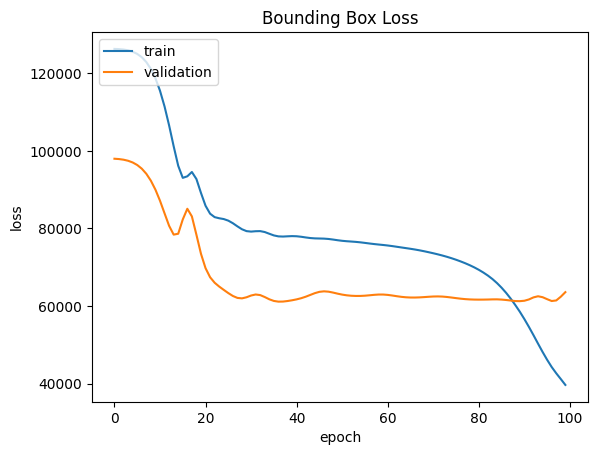

In [18]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

